In [338]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import plotly.express as px

In [339]:
def plot_current(dataframe):
    fig = px.line(x=dataframe.iloc[:,0],y=dataframe.iloc[:,1],title="current diagram")
    fig.update_layout(xaxis_title="time (mS)", yaxis_title="current(pA)")
    fig.show()

In [340]:
class CurrentDataset(torch.utils.data.Dataset):
    """current dataset"""

    def __init__(self,file_path):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        # self.file_path = file_path
        # self.data = pd.read_csv(file_path)
        self.data = file_path
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data.loc[idx].values
        return torch.tensor(sample)

In [341]:
class LIF(torch.nn.Module):
    """
    Leaky Integrate and Fire model for neuron dynamic
    """
    
    def __init__(self,R,tau,u_rest,threshold):
        """
        Args:
            R : Circuit resistance equivalent to neuron gates (MΩ)
            tau : Time constant of the neuron (mS)
            u_rest : Resting potential of the neuron (mV)
            threshold : spiking threshold of the neuron (mV)
        """
        super(LIF, self).__init__()
        self.R=R
        self.tau=tau
        self.u=u_rest
        self.u_rest=u_rest
        self.threshold=threshold
        self.time = 0
        self.history = torch.tensor([self.time,self.u])
        self.frequency = torch.tensor([0,0])

    def forward(self,x):
        dt = x[0] - self.time
        self.time = x[0]
        du=dt*(-1*(self.u-self.u_rest)+self.R*x[1])/self.tau
        self.u +=du
        temp = x[0] + self.tau* np.log((self.R*x[1])/(self.R*x[1]+self.u_rest-self.u))
        temp = 1/temp
        if self.u>self.threshold:
            self.to_rest()
            self.history = torch.vstack((self.history,torch.tensor([self.time,self.u])))
            # self.frequency = torch.vstack((self.frequency,torch.tensor(temp)))
#             self.frequency = torch.vstack((self.frequency,torch.tensor([x[1],self.time])))
            self.frequency = torch.vstack((self.frequency,torch.tensor([x[1],temp])))

            return torch.tensor([[self.time,1,x[1]]])
        else :
            # self.frequency = torch.vstack((self.frequency,torch.tensor(temp)))
            self.history = torch.vstack((self.history,torch.tensor([self.time,self.u])))
            self.frequency = torch.vstack((self.frequency,torch.tensor([x[1],temp])))
            return torch.tensor([[self.time,0,x[1]]])
        
    def reset(self):
        self.u=self.u_rest
        self.time = 0
        self.history = torch.tensor([self.time,self.u])
        
    
    def to_rest(self):
        self.u=self.u_rest

In [342]:
def freuquency_calculator(history):
    spike_time = []
    
    for i in history:
        if(history[1]==1):
            spike_time.append(history[0])
    diff_spike_time = [spike_time[0]]
    
    for i in range(len(spike_time)):
        diff_spike_time.append(spike_time[i+1]-spike_time[i])
    return diff_spike_time

In [343]:
def process(model,dataloader):
    spikes_data =None
    for data in dataloader:
        result = model(data[0])
        if spikes_data is None:
            spikes_data = result
        else :
            spikes_data = torch.vstack((spikes_data,result))
    return spikes_data

In [344]:
def plot_spikes(spikes):
    spike_points = spikes[spikes[:,1]==1.0]
    fig = plt.figure(figsize=(10,5))
    plt.scatter(spike_points[:,0],spike_points[:,1],marker='|',c='r',s=500)
    plt.xlabel("time (mS)")
    plt.yticks(ticks=[1],labels=['spike'])
    plt.grid()
    plt.title("Spike points diagram")
    plt.show()

In [345]:
def plot_history(history):
    fig = px.line(x= history[:,0],y=history[:,1],title="PSP diagram")
    fig.update_layout(xaxis_title="time (mS)", yaxis_title="Voltage(mV)")
    fig.show()

In [346]:
def plot_frequency(history,data_length):
    fig = px.line(x= history[1:,0],y=history[1:,1]/400,title="PSP diagram")
    fig.update_layout(xaxis_title="I(t)", yaxis_title="f=1/T")
    fig.show()

In [347]:
def freuquency_calculator(history):
    spike_time = []
    for i in history:
        if(i[1] ==1):
            spike_time.append([i[0].item(),i[2].item()])
    diff_spike_time = []
    for i in range(len(spike_time)-1):
        diff_spike_time.append((1/(spike_time[i+1][0]-spike_time[i][0]),spike_time[i][1]))
    diff_spike_time = pd.DataFrame(diff_spike_time)

    fig = px.line(x= diff_spike_time.iloc[1:,1],y=diff_spike_time.iloc[1:,0],title="F-I curve")
    fig.update_layout(xaxis_title="I (A)", yaxis_title="f=1/T")
    fig.show()

In [371]:
def run(data,R,tau,u_rest,threshold,iteration):
    R = R
    tau = tau
    u_rest = u_rest
    threshold = threshold

    model = LIF(R,tau,u_rest,threshold)
    
    step = CurrentDataset(data)
    linear_current_dataloader = torch.utils.data.DataLoader(step, batch_size=1, shuffle=False)
    spikes_information = process(model, linear_current_dataloader)

    plot_current(data)
    plot_spikes(spikes_information)
    plot_history(model.history)
    plot_frequency(model.frequency,len(data))
    freuquency_calculator(spikes_information)
    model = model.reset()
    print("The iteration {} done:)".format(iteration))

In [349]:
# Initializing LIF model
# R(MΩ)
R = 0.01 
# tau (mS)
tau = 8
# u_rest (mV)
u_rest = -65
# threshold (mV)
threshold = -50

model = LIF(R,tau,u_rest,threshold)

In [350]:
data = []
for k in range(1,6):
    y = np.array([[i]*5 for i in range(3500,7001,100*k)]).flatten()
    X = np.array([i for i in range(len(y))])
    temp = pd.DataFrame([X,y]).T
    data.append(temp)

In [351]:
# y = np.array([[0]*100,[2500]*100]).flatten()
# X = np.array([i for i in range(len(y))])


/tmp/ipykernel_4119/3678489722.py:29: RuntimeWarning:

invalid value encountered in log



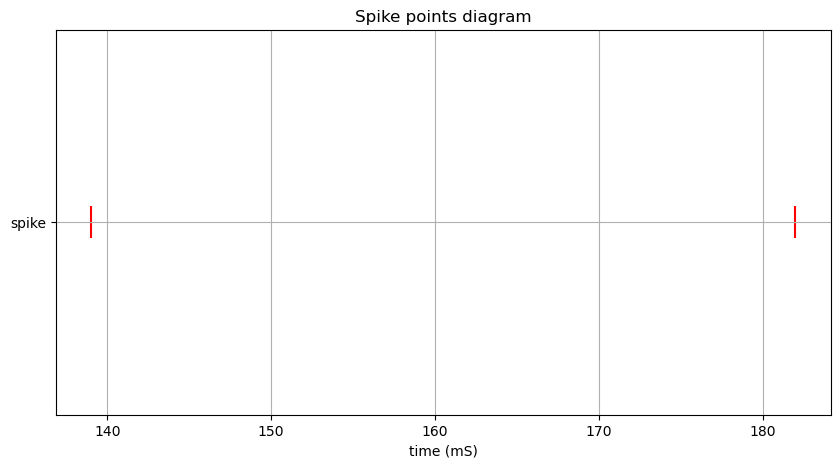

ValueError: Cannot accept list of column references or list of columns for both `x` and `y`.

In [372]:
R = 0.01
# tau (mS)
tau = 8
# u_rest (mV)
u_rest = -65
# threshold (mV)
threshold = -10
for datas,index in zip(data,range(len(data))):
    run(datas,R,tau,u_rest,threshold,index)

In [373]:
from random import randrange
data = []
for i in range(10):
    y = []
    for i in range(200):
        y.append(randrange(3000,7000)+randrange(200))
    X = np.array([i for i in range(len(y))])
    temp = pd.DataFrame([X,y]).T
    data.append(temp)

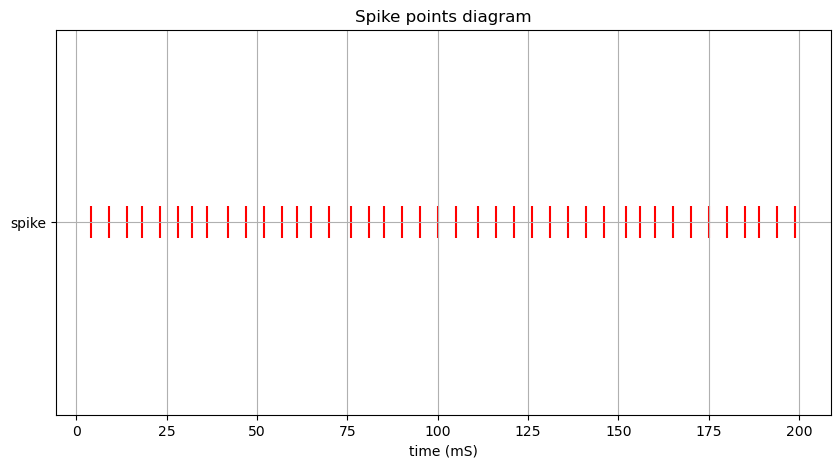

The iteration 0 done:)


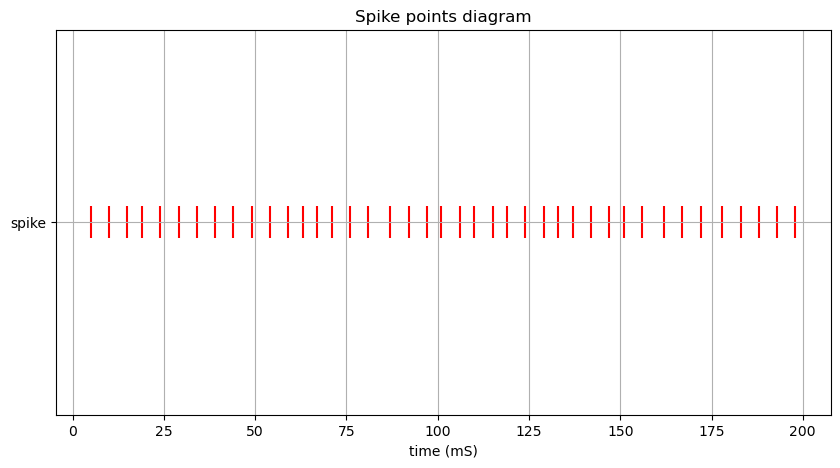

The iteration 1 done:)


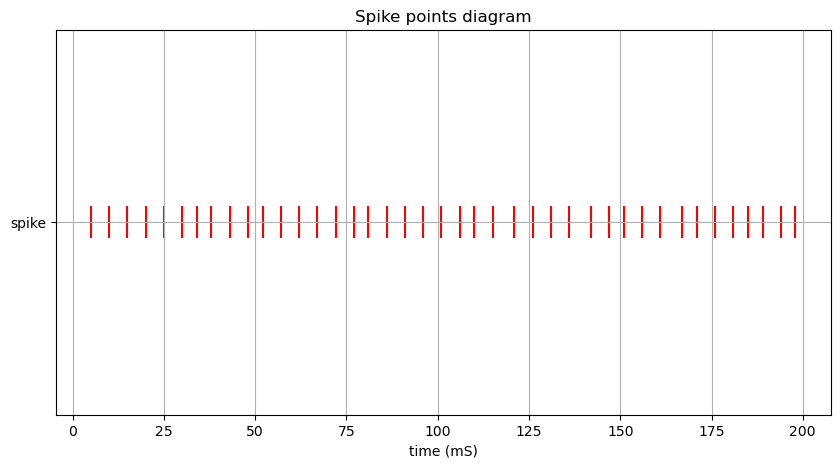

The iteration 2 done:)


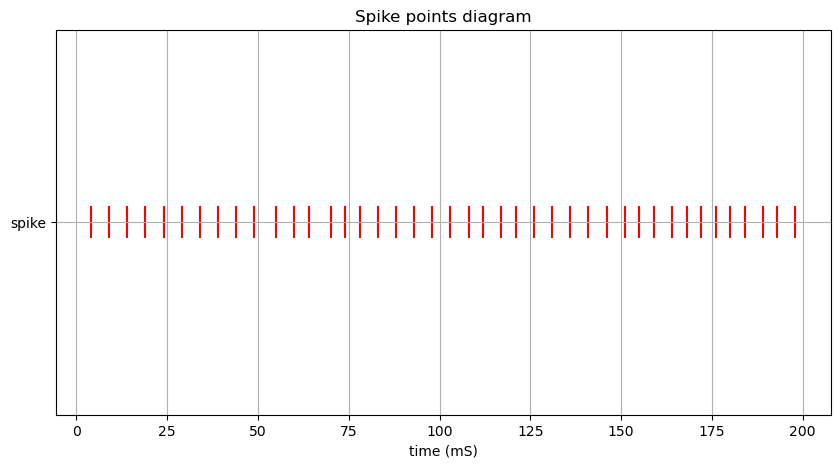

The iteration 3 done:)


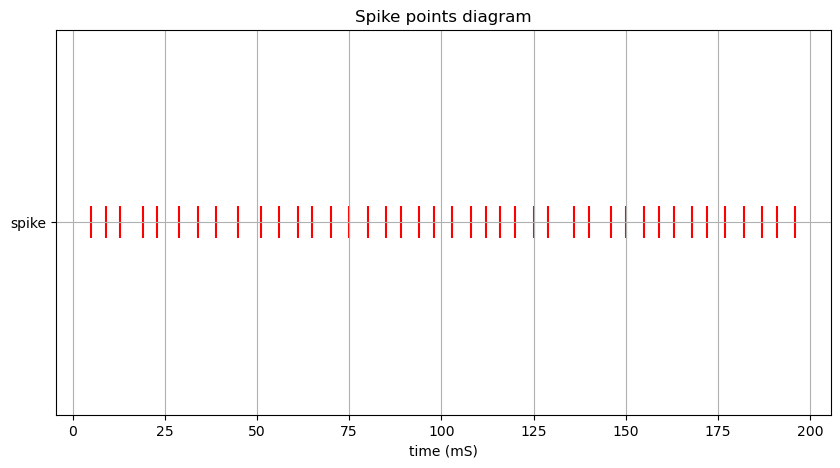

The iteration 4 done:)


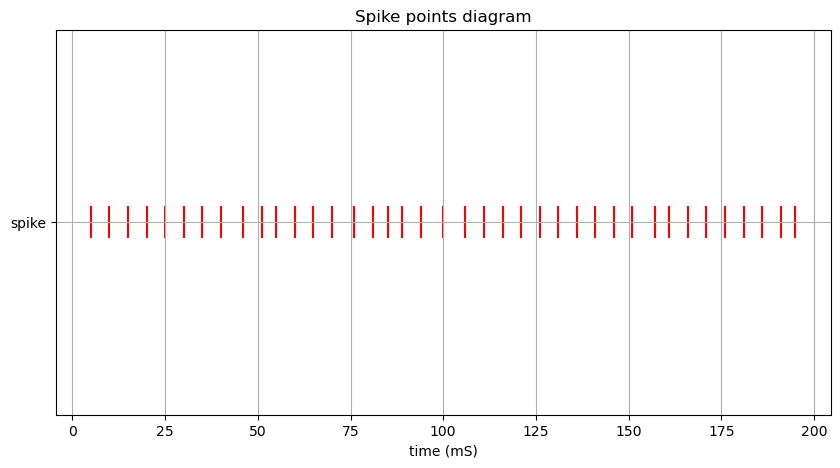

The iteration 5 done:)


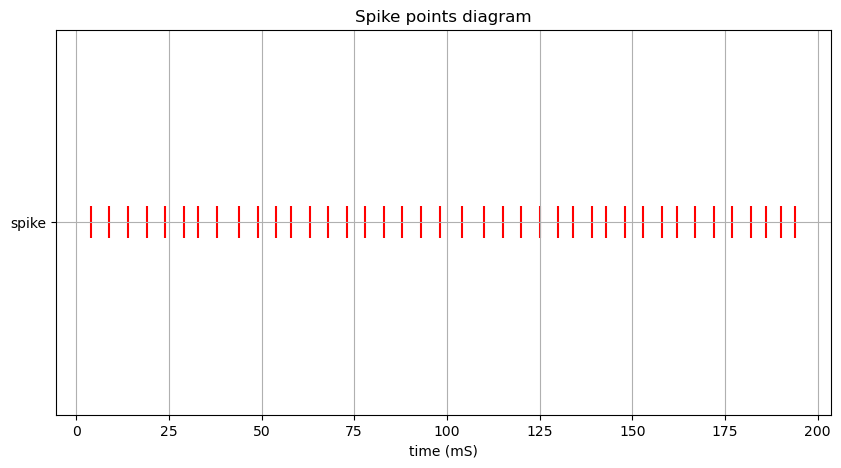

The iteration 6 done:)


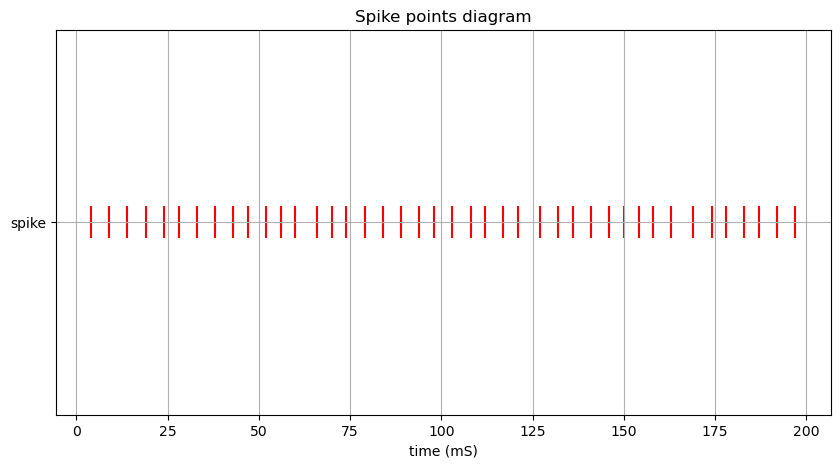

The iteration 7 done:)


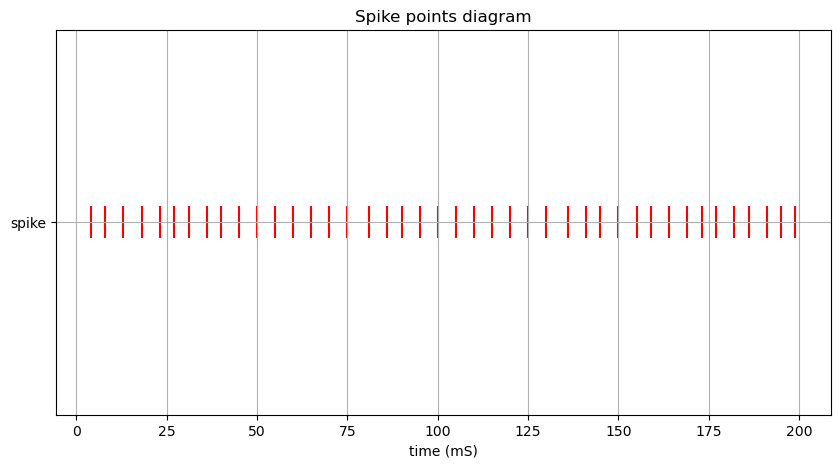

The iteration 8 done:)


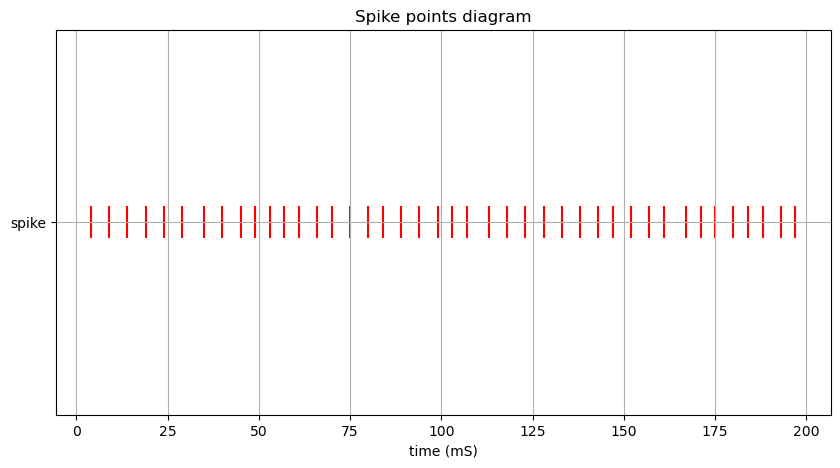

The iteration 9 done:)


In [382]:
R = 0.01 
# tau (mS)
tau = 20
# u_rest (mV)
u_rest = -65
# threshold (mV)
threshold = -55
for datas,index in zip(data,range(len(data))):
    run(datas,R,tau,u_rest,threshold,index)

In [44]:
from random import randrange
data = []
for i in range(10):
    y = []
    for i in range(200):
        y.append(randrange(100,5000)+randrange(200))
    X = np.array([i for i in range(len(y))])
    temp = pd.DataFrame([X,y]).T
    data.append(temp)

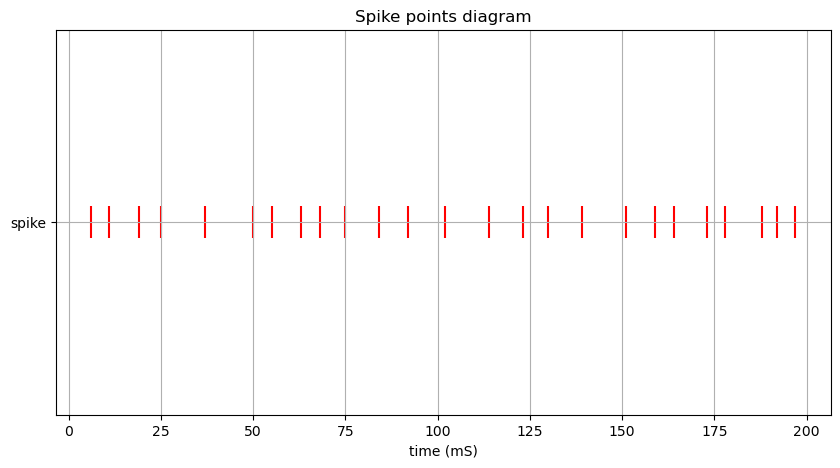

The iteration 0 done:)


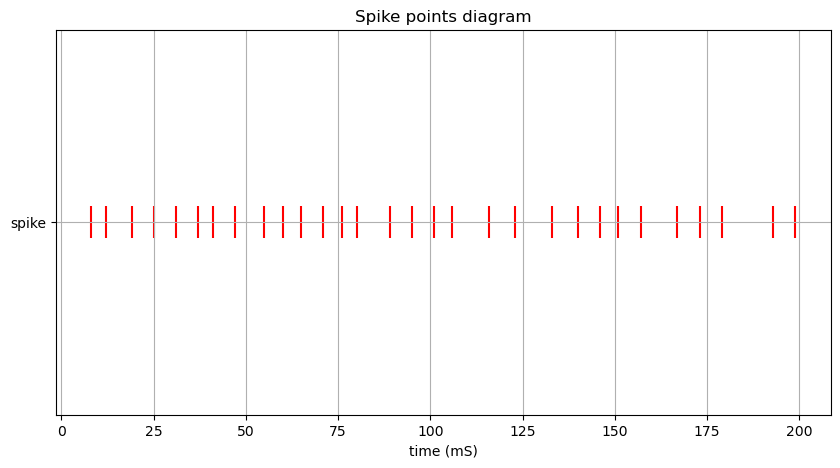

The iteration 1 done:)


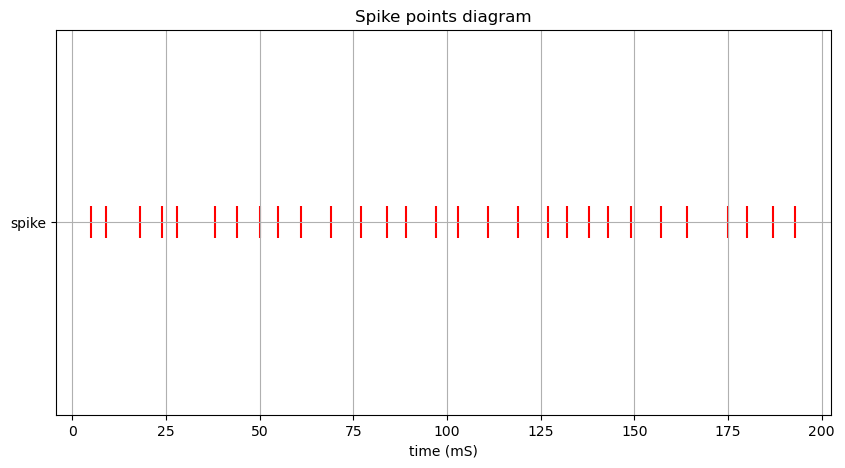

The iteration 2 done:)


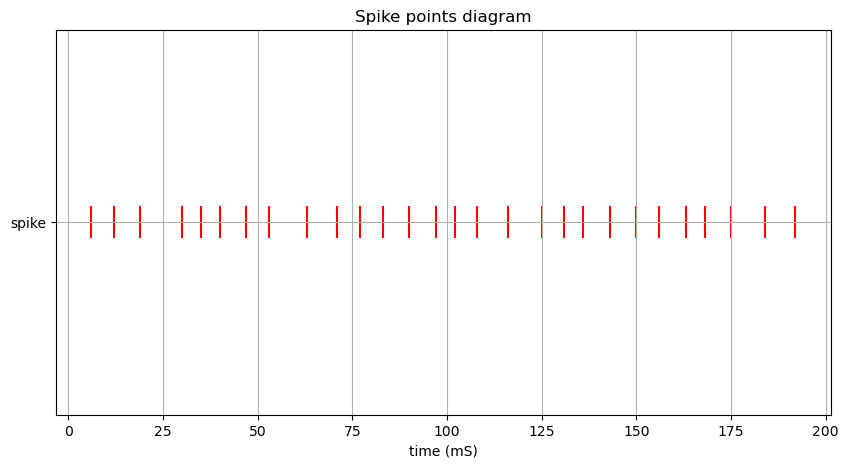

The iteration 3 done:)


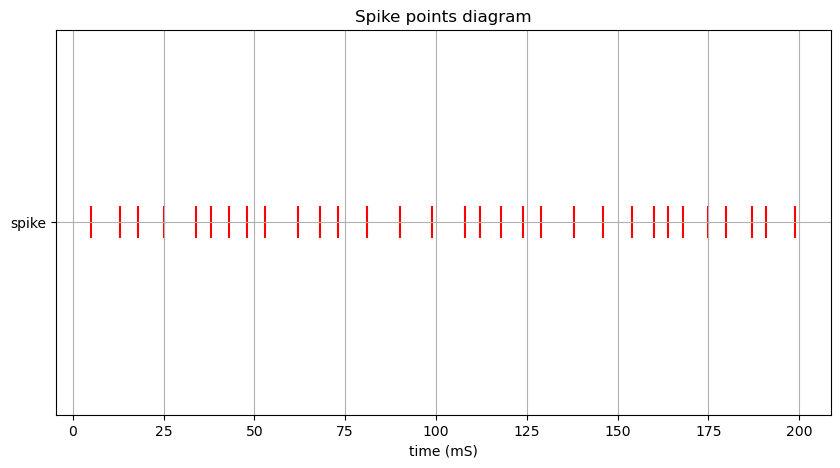

The iteration 4 done:)


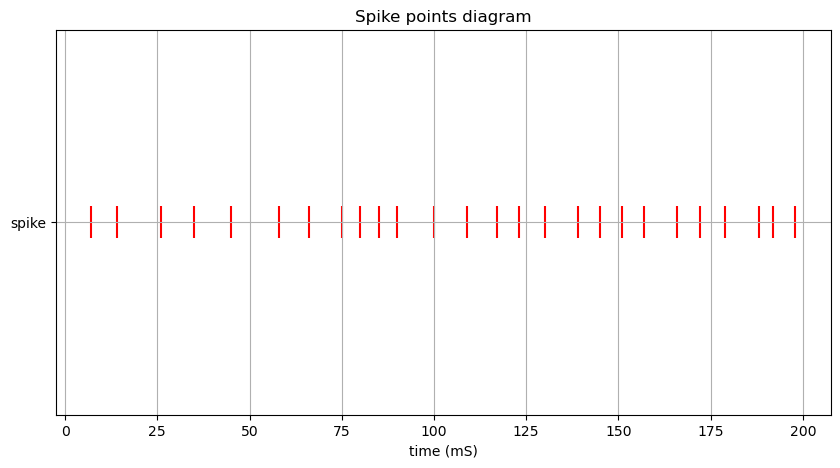

The iteration 5 done:)


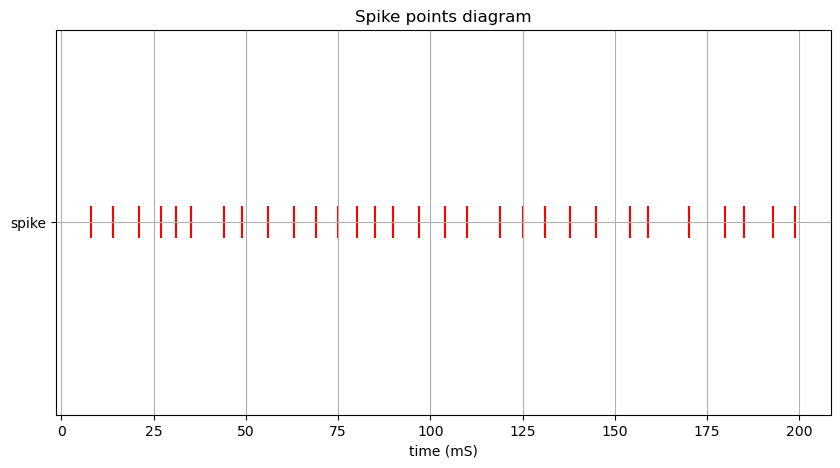

The iteration 6 done:)


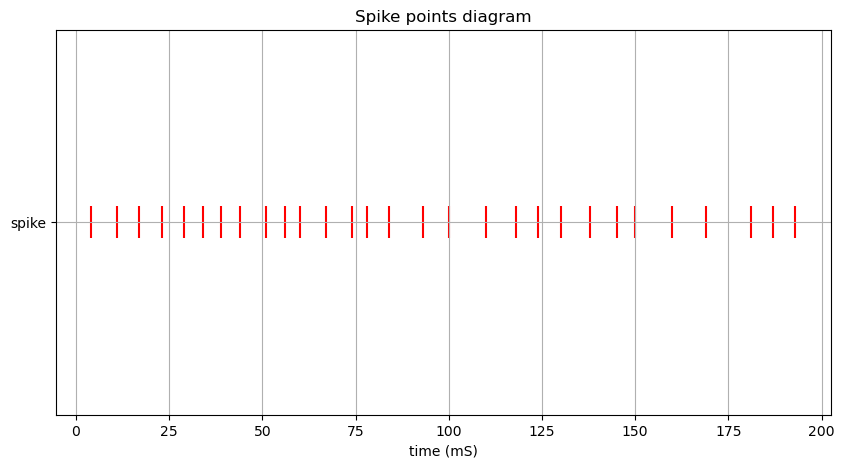

The iteration 7 done:)


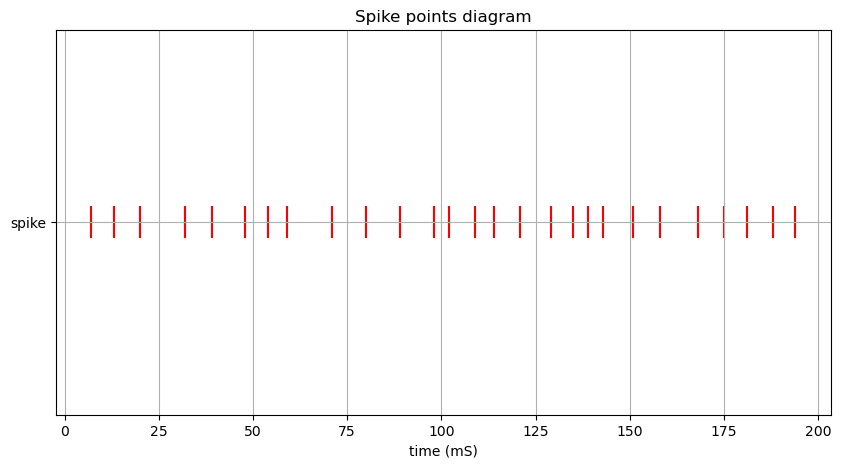

The iteration 8 done:)


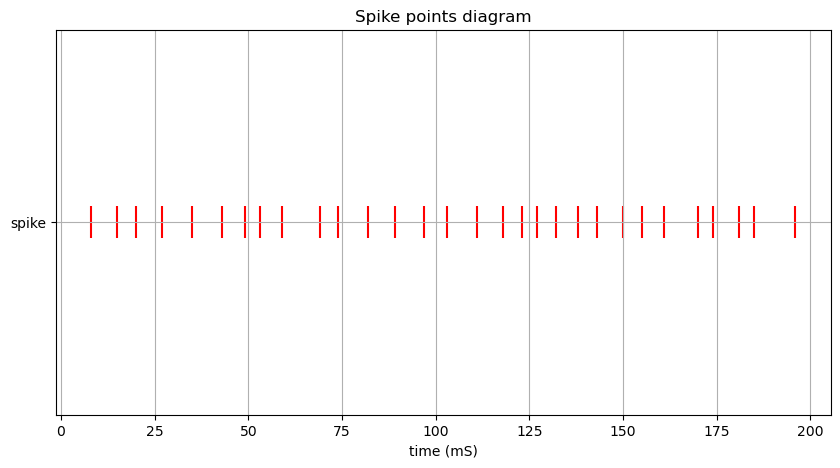

The iteration 9 done:)


In [45]:
R = 0.01 
# tau (mS)
tau = 8
# u_rest (mV)
u_rest = -65
# threshold (mV)
threshold = -50
for datas,index in zip(data,range(len(data))):
    run(datas,R,tau,u_rest,threshold,index)

In [107]:
R = 0.01 
# tau (mS)
tau = 8
# u_rest (mV)
u_rest = -65
# threshold (mV)
threshold = -50

In [389]:
data = pd.read_csv('./BTC-Hourly.csv')

In [390]:
y = data['open'][0:1000]/20

X = np.array([i for i in range(len(y))])
data = pd.DataFrame([X,y]).T


In [391]:
temp.columns


RangeIndex(start=0, stop=2, step=1)

/tmp/ipykernel_4119/3678489722.py:29: RuntimeWarning:

invalid value encountered in log



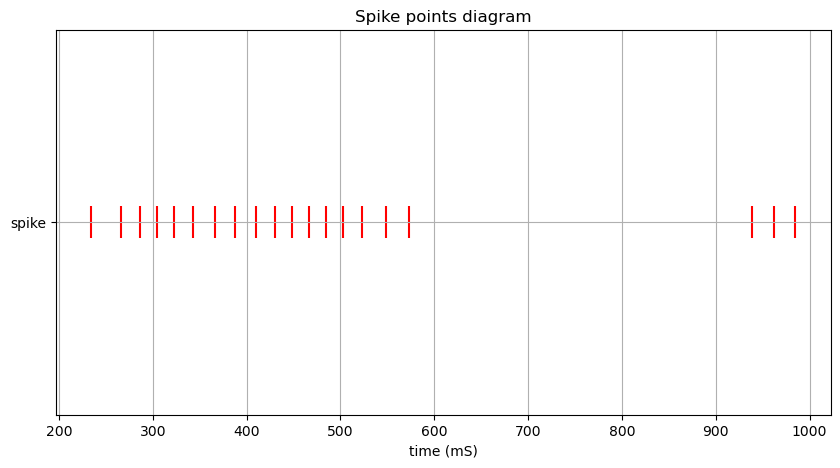

The iteration 1 done:)


In [395]:
R = 0.01 
# tau (mS)
tau = 8
# u_rest (mV)
u_rest = -70
# threshold (mV)
threshold = -50
run(data,R,tau,u_rest,threshold,1)

In [91]:
def freuquency_calculator(history):
    spike_time = []
    for i in history:
        if(i[1] ==1):
            spike_time.append(i[0].item())
    diff_spike_time = []
    print(spike_time)
    for i in range(len(spike_time)-1):
        diff_spike_time.append(1/(spike_time[i+1]-spike_time[i]))
    X = np.array([i for i in range(len(diff_spike_time))])
    plt.plot(diff_spike_time)
    return diff_spike_time

[11.0, 20.0, 32.0, 43.0, 53.0, 61.0, 68.0, 76.0, 84.0, 90.0, 96.0, 102.0, 107.0, 112.0, 117.0, 122.0, 128.0, 133.0, 139.0, 145.0, 154.0, 163.0, 171.0, 178.0, 186.0, 194.0, 202.0, 212.0, 231.0, 247.0, 260.0, 273.0, 285.0, 293.0, 299.0, 305.0, 312.0, 318.0, 323.0, 329.0, 335.0, 342.0, 348.0, 354.0, 361.0, 369.0, 376.0, 384.0, 401.0, 415.0]


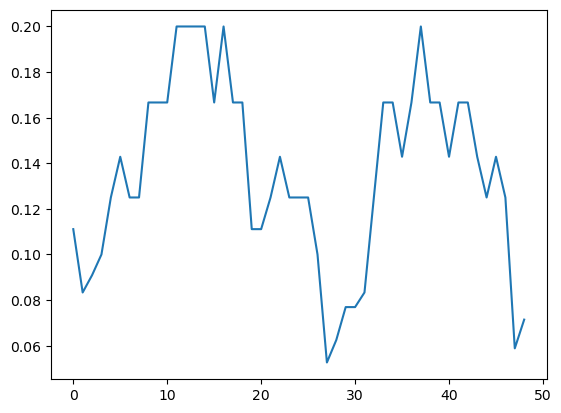

In [92]:
a = freuquency_calculator(spikes_information)

In [83]:
X = np.array([i for i in range(len(a))])


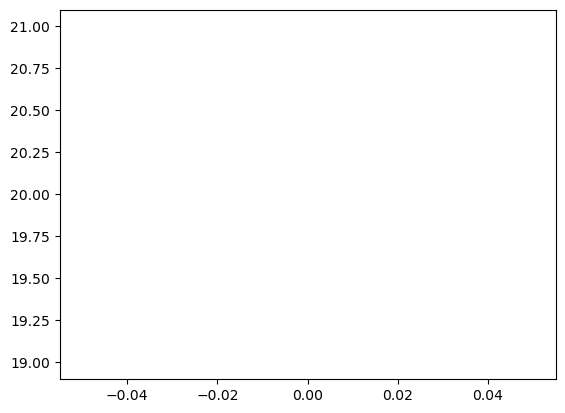

In [86]:
plt.plot(np.array(20))

/tmp/ipykernel_4119/4058634279.py:29: RuntimeWarning:

invalid value encountered in log



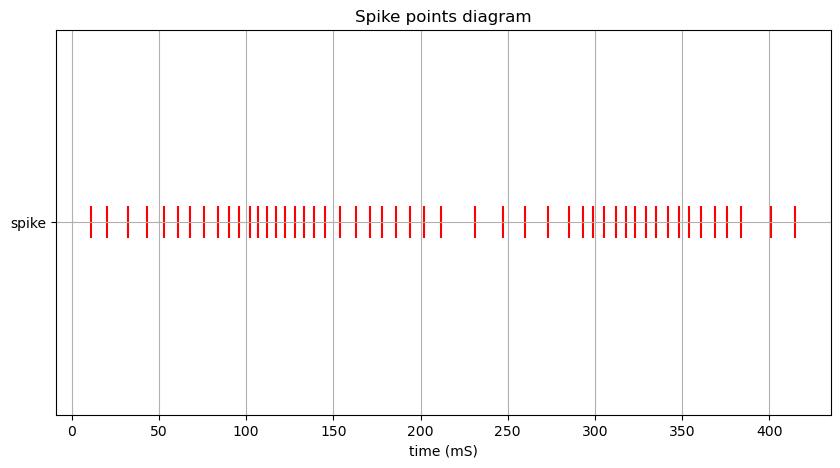

In [48]:
model = LIF(R,tau,u_rest,threshold)
    
step = CurrentDataset(data)
linear_current_dataloader = torch.utils.data.DataLoader(step, batch_size=1, shuffle=False)
spikes_information = process(model, linear_current_dataloader)

plot_current(data)
plot_spikes(spikes_information)
plot_history(model.history)
plot_frequency(model.frequency,len(data))
